<a href="https://colab.research.google.com/github/Rahulraj31/Chest_Xray_Pneumonia/blob/main/VGG_Chest_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center>
Pneumonia Diagnosis: Convnet Model</h1>


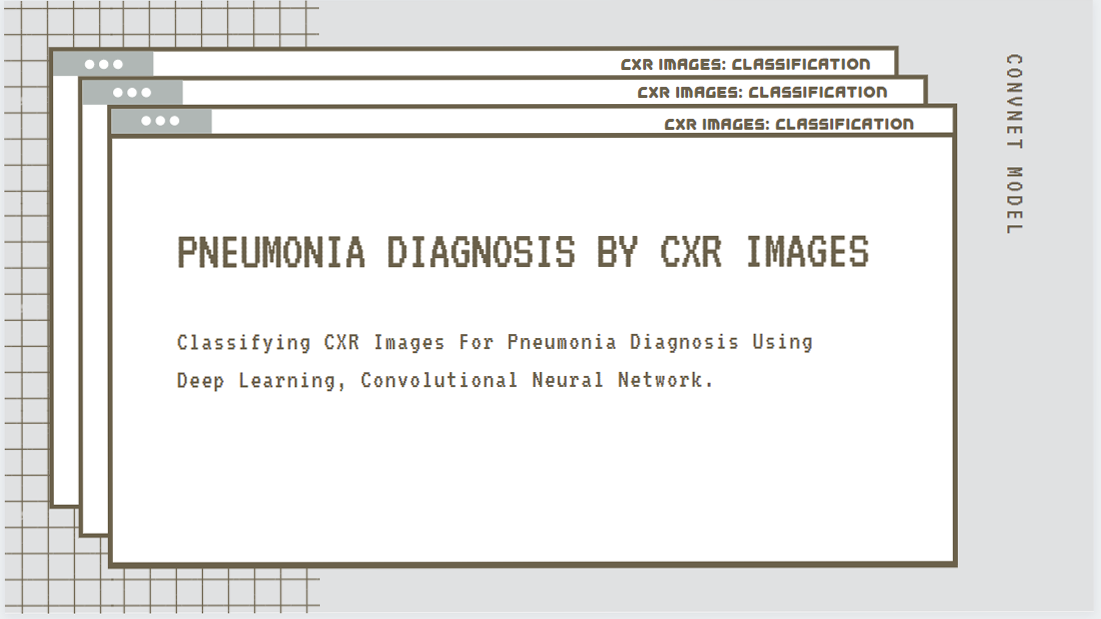

# Importing Libraries

In [1]:
import PIL.Image as Image
import cv2
import numpy as np
import pandas as pd

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/chest X ray - Sorted.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Loading Data

In [4]:
from pathlib import Path 
# Define path to the data directory
dir_alldata = Path('/content/chest_xray')

# Path to train directory 
train_data_dir = dir_alldata / 'train'

# Path to validation directory
validation_data_dir = dir_alldata / 'val'

# Path to test directory
test_data_dir = dir_alldata / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir / 'NORMAL'
pneumonia_cases_train = train_data_dir / 'PNEUMONIA'

In [5]:
train_images_dict = {
    'normal': list(normal_cases_train.glob('*')) ,   
    'pneumonia': list(pneumonia_cases_train.glob('*'))  
}

test_images_dict = {
    'normal': list(test_data_dir.glob('NORMAL/*')) ,   
    'pneumonia': list(test_data_dir.glob('PNEUMONIA/*'))  
}

val_images_dict = {
    'normal': list(validation_data_dir.glob('NORMAL/*')) ,   
    'pneumonia': list(validation_data_dir.glob('PNEUMONIA/*'))  
}


labels_dict = {
    'normal': "normal",
    'pneumonia': "pneumonia",
    
}

In [6]:
img= cv2.imread(str(train_images_dict['pneumonia'][0]))
img.shape

(1088, 1488, 3)

In [7]:
img= cv2.imread(str(test_images_dict['normal'][10]))
img.shape

(1620, 1992, 3)

In [8]:
img= cv2.imread(str(val_images_dict['normal'][0]))
img.shape

(1416, 1776, 3)

# Making Train Test Validation Datset





In [9]:
Xtrain, ytrain = [], []
for name,images in train_images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)
    
        Xtrain.append(img)
        ytrain.append(labels_dict[name])


Fseries = pd.Series(Xtrain, name="filepaths",dtype=str)
Lseries = pd.Series(ytrain, name="labels",dtype=str)
train_data = pd.concat([Fseries,Lseries], axis=1)
train_df = pd.DataFrame(train_data)

In [10]:
print(train_df["labels"].value_counts())

pneumonia    3875
normal       1341
Name: labels, dtype: int64


In [11]:
Xtest, ytest = [], []
for name,images in test_images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)
    
        Xtest.append(img)
        ytest.append(labels_dict[name])


Fseries = pd.Series(Xtest, name="filepaths",dtype=str)
Lseries = pd.Series(ytest, name="labels",dtype=str)
test_data = pd.concat([Fseries,Lseries], axis=1)
test_df = pd.DataFrame(test_data)

In [12]:
test_df["labels"].value_counts()

pneumonia    390
normal       234
Name: labels, dtype: int64

In [13]:
Xval, yval = [], []
for name,images in val_images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)
    
        Xval.append(img)
        yval.append(labels_dict[name])


Fseries = pd.Series(Xval, name="filepaths",dtype=str)
Lseries = pd.Series(yval, name="labels",dtype=str)
val_data = pd.concat([Fseries,Lseries], axis=1)
val_df = pd.DataFrame(val_data)

val_df["labels"].value_counts()

normal       8
pneumonia    8
Name: labels, dtype: int64

In [14]:
#shape of data
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(5216, 2)
(624, 2)
(16, 2)


# **Data Augmentation**

In [16]:
#Generate batches of tensor image data with real-time data augmentation.
# real world data is nto augmented
image_gen = ImageDataGenerator(rescale = 1./255,
                                   
                                   #randomly rotate images
                                   rotation_range = 40,
                                   
                                   #randomly shear angles
                                   shear_range = 0.2,
                                   
                                   #randomly zoom images
                                   zoom_range = 0.2,
                                   
                                   #randomly shift images
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   
                                   # randomly flip images
                                   horizontal_flip = True,
                                   
                                   fill_mode = 'nearest'
    
)

test_gen=ImageDataGenerator(rescale = 1./255)

train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(150,150),
                                     
                                      class_mode="binary", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = test_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(150,150),
                                     
                                     class_mode="binary",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(150,150),
                                   
                                    class_mode="binary",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [17]:
classes=list(train.class_indices.keys())
print (classes)

['normal', 'pneumonia']


# Model Building

In [18]:
from tensorflow.keras.applications import VGG16

cnn_base = VGG16(include_top = False,
                 weights = 'imagenet',
                 input_shape = (150, 150, 3),
                 classes = 2,
                 classifier_activation = 'sigmoid')

cnn_base.trainable = False

In [19]:
pretrainedCNN_model = Sequential([
                                     cnn_base,
                                  layers.Flatten(),
                                  layers.Dense(640, activation = 'relu'),
layers.Dropout(0.5),
layers.Dense(128, activation = 'relu'),
layers.Dropout(0.5),
                                     layers.Dense(1, activation = 'sigmoid')  ,  
])

In [20]:
pretrainedCNN_model.compile(loss = 'binary_crossentropy',
                            optimizer = keras.optimizers.Adam(0.0001),
                            metrics = ['acc'])

In [21]:
pretrainedCNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               5243520   
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

# Model Training

In [22]:
History = pretrainedCNN_model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
163/163 [==============================] - 77s 439ms/step - loss: 0.4862 - acc: 0.7627 - val_loss: 0.6812 - val_acc: 0.7500
Epoch 2/10
163/163 [==============================] - 70s 431ms/step - loss: 0.3097 - acc: 0.8608 - val_loss: 0.7266 - val_acc: 0.5625
Epoch 3/10
163/163 [==============================] - 70s 427ms/step - loss: 0.3130 - acc: 0.8600 - val_loss: 0.8119 - val_acc: 0.5625
Epoch 4/10
163/163 [==============================] - 70s 428ms/step - loss: 0.2686 - acc: 0.8857 - val_loss: 1.0029 - val_acc: 0.6875
Epoch 5/10
163/163 [==============================] - 73s 446ms/step - loss: 0.2439 - acc: 0.8974 - val_loss: 0.5926 - val_acc: 0.8125
Epoch 6/10
163/163 [==============================] - 69s 423ms/step - loss: 0.2267 - acc: 0.9041 - val_loss: 0.7315 - val_acc: 0.6875
Epoch 7/10
163/163 [==============================] - 69s 424ms/step - loss: 0.2291 - acc: 0.9107 - val_loss: 1.0828 - val_acc: 0.6875
Epoch 8/10
163/163 [==============================] - 7

# Evaluation

In [23]:
pretrainedCNN_model.evaluate(test)

20/20 [==============================] - 5s 255ms/step - loss: 0.3105 - acc: 0.8574


[0.31050702929496765, 0.8573718070983887]

<h1 align = center>THE END</h1> 